In [1]:
from tools.utils import *
from tools.het_networks import *
from itertools import product

import torch

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# Random
seed = 42

# Model
hidden_channels = 256
num_classes = 6
num_layers = 2
aggr_opts = ['sum', 'mean', 'max']
aggr_list = list(product(aggr_opts, repeat=2))
print(aggr_list)
# intra_aggr='mean' varying
# inter_aggr='sum' varying
dropout = 0.5
use_skip_connections = True

# Training
batch_size = 32
epochs = 30
decay = 1e-4
lr = 1e-4
maxlr = 3e-4

# Experiments iteration
i = 0

[('sum', 'sum'), ('sum', 'mean'), ('sum', 'max'), ('mean', 'sum'), ('mean', 'mean'), ('mean', 'max'), ('max', 'sum'), ('max', 'mean'), ('max', 'max')]


# Preprocessing

In [3]:
# Load the ENZYMES dataset
hom_dataset = TUDataset(root='data', name='ENZYMES')                          # This has 3 one-hot encodings
hom_dataset_attr = TUDataset(root='data', name='ENZYMES', use_node_attr=True) # This has 3 one-hot encodings and 18 features

In [4]:
def normalize_enzymes_data(data):
    data = data.clone()
    if hasattr(data, 'x') and data.x is not None:
        x = data.x
        feats = x[:, :18]
        mean = feats.mean(dim=0)
        std = feats.std(dim=0, unbiased=False)
        std[std == 0] = 1.0
        normalized_feats = (feats - mean) / std
        x[:, :18] = normalized_feats
        data.x = x
    return data

# Normalize features
normalized_hom_dataset_attr = [normalize_enzymes_data(hom_data) for hom_data in hom_dataset_attr]

In [5]:
# Construct het dataset
het_dataset = []
for hom_data in normalized_hom_dataset_attr:
    het_data = convert_hom_to_het(hom_data, onehot_indices=[18, 19, 20], is_directed=False)
    het_dataset.append(het_data)
het_dataset.__len__()

600

In [6]:
# Get the metadata to build HeteroGNN
edge_types = het_dataset[0].edge_types
node_types = het_dataset[0].node_types
metadata = (node_types, edge_types)
metadata

(['A', 'B', 'C'],
 [('A', 'edge_index', 'A'),
  ('A', 'edge_index', 'B'),
  ('A', 'edge_index', 'C'),
  ('B', 'edge_index', 'B'),
  ('B', 'edge_index', 'C'),
  ('C', 'edge_index', 'C')])

In [7]:
# Create splits
labels = [data.y.item() for data in het_dataset]

train_set, temp_set = train_test_split(
    het_dataset, 
    test_size=0.3, 
    stratify=labels,
    random_state=seed
    
)

temp_labels = [data.y.item() for data in temp_set]
valid_set, test_set = train_test_split(
    temp_set, 
    test_size=0.5, 
    stratify=temp_labels,
    random_state=seed
)

# train_loader is defined at each experiment for reproducibility
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# ('sum', 'sum')

Epoch 1/30
Train Loss: 1.8096 | Validation Loss: 1.7958
Train Acc: 0.1500 | Validation Acc: 0.1556
Train F1: 0.0791 | Validation F1: 0.0453

Epoch 2/30
Train Loss: 1.7980 | Validation Loss: 1.7915
Train Acc: 0.1762 | Validation Acc: 0.1111
Train F1: 0.1351 | Validation F1: 0.1089

Epoch 3/30
Train Loss: 1.7864 | Validation Loss: 1.7871
Train Acc: 0.1857 | Validation Acc: 0.2222
Train F1: 0.1803 | Validation F1: 0.1610

Epoch 4/30
Train Loss: 1.7794 | Validation Loss: 1.7805
Train Acc: 0.1952 | Validation Acc: 0.2222
Train F1: 0.1675 | Validation F1: 0.1277

Epoch 5/30
Train Loss: 1.7700 | Validation Loss: 1.7643
Train Acc: 0.1857 | Validation Acc: 0.2667
Train F1: 0.1593 | Validation F1: 0.2393

Epoch 6/30
Train Loss: 1.7396 | Validation Loss: 1.7508
Train Acc: 0.2595 | Validation Acc: 0.2444
Train F1: 0.2202 | Validation F1: 0.1844

Epoch 7/30
Train Loss: 1.7242 | Validation Loss: 1.7267
Train Acc: 0.2667 | Validation Acc: 0.2889
Train F1: 0.2268 | Validation F1: 0.2427

Epoch 8/30
Tr

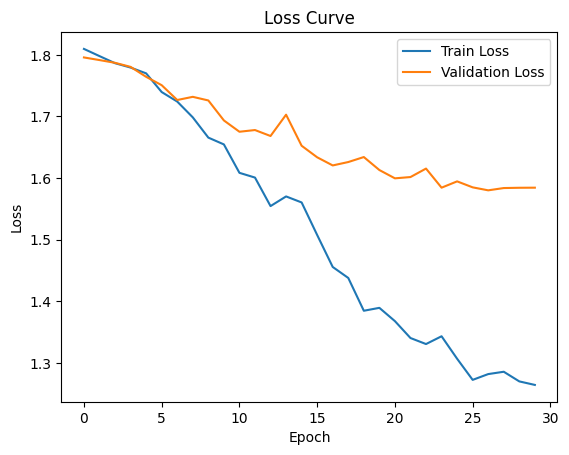

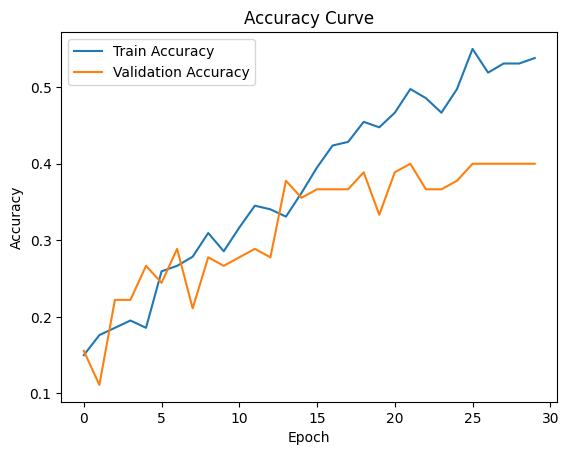

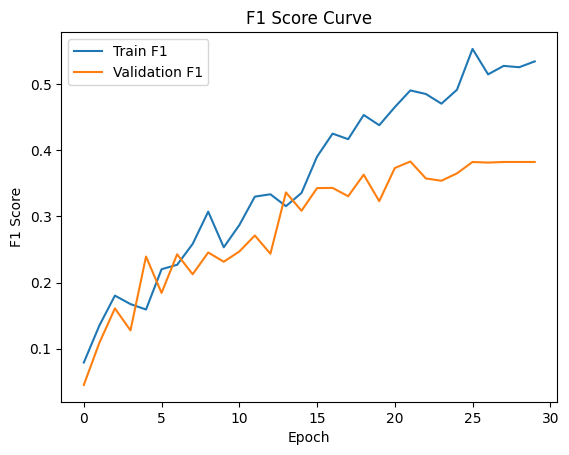

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8096,1.7958,0.1500,0.1556,0.0791,0.0453
1,2,1.7980,1.7915,0.1762,0.1111,0.1351,0.1089
2,3,1.7864,1.7871,0.1857,0.2222,0.1803,0.1610
3,4,1.7794,1.7805,0.1952,0.2222,0.1675,0.1277
4,5,1.7700,1.7643,0.1857,0.2667,0.1593,0.2393
5,6,1.7396,1.7508,0.2595,0.2444,0.2202,0.1844
6,7,1.7242,1.7267,0.2667,0.2889,0.2268,0.2427
7,8,1.6985,1.7319,0.2786,0.2111,0.2584,0.2125
8,9,1.6657,1.7260,0.3095,0.2778,0.3072,0.2455
9,10,1.6546,1.6935,0.2857,0.2667,0.2533,0.2315


In [8]:
intra_aggr, inter_aggr = aggr_list[i]
i += 1

experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# ('sum', 'mean')

Epoch 1/30
Train Loss: 1.8061 | Validation Loss: 1.7969
Train Acc: 0.1548 | Validation Acc: 0.1556
Train F1: 0.0924 | Validation F1: 0.0453

Epoch 2/30
Train Loss: 1.7981 | Validation Loss: 1.7936
Train Acc: 0.1905 | Validation Acc: 0.1333
Train F1: 0.1540 | Validation F1: 0.0702

Epoch 3/30
Train Loss: 1.7886 | Validation Loss: 1.7899
Train Acc: 0.1786 | Validation Acc: 0.2111
Train F1: 0.1680 | Validation F1: 0.1417

Epoch 4/30
Train Loss: 1.7825 | Validation Loss: 1.7851
Train Acc: 0.1762 | Validation Acc: 0.2111
Train F1: 0.1502 | Validation F1: 0.1111

Epoch 5/30
Train Loss: 1.7782 | Validation Loss: 1.7739
Train Acc: 0.1643 | Validation Acc: 0.2556
Train F1: 0.1392 | Validation F1: 0.2078

Epoch 6/30
Train Loss: 1.7529 | Validation Loss: 1.7644
Train Acc: 0.2500 | Validation Acc: 0.2556
Train F1: 0.2110 | Validation F1: 0.1824

Epoch 7/30
Train Loss: 1.7355 | Validation Loss: 1.7456
Train Acc: 0.2524 | Validation Acc: 0.2333
Train F1: 0.2121 | Validation F1: 0.1545

Epoch 8/30
Tr

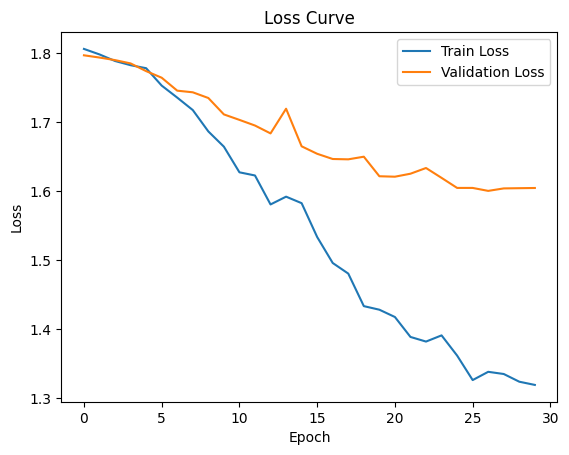

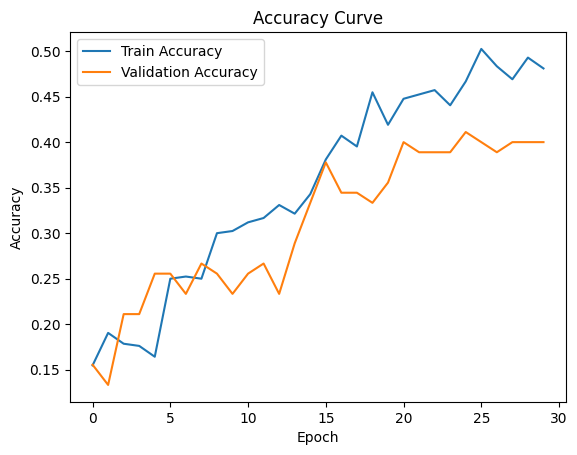

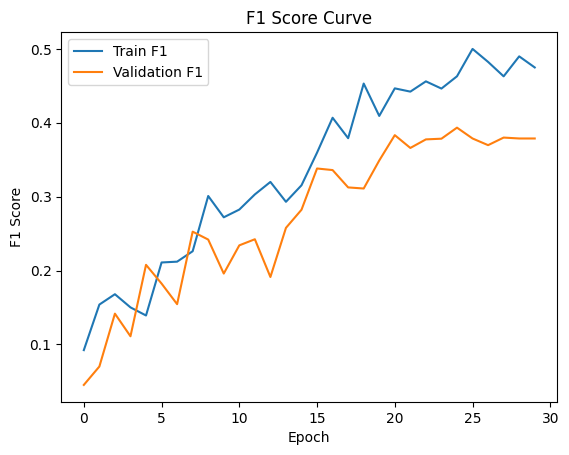

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8061,1.7969,0.1548,0.1556,0.0924,0.0453
1,2,1.7981,1.7936,0.1905,0.1333,0.1540,0.0702
2,3,1.7886,1.7899,0.1786,0.2111,0.1680,0.1417
3,4,1.7825,1.7851,0.1762,0.2111,0.1502,0.1111
4,5,1.7782,1.7739,0.1643,0.2556,0.1392,0.2078
5,6,1.7529,1.7644,0.2500,0.2556,0.2110,0.1824
6,7,1.7355,1.7456,0.2524,0.2333,0.2121,0.1545
7,8,1.7175,1.7432,0.2500,0.2667,0.2262,0.2526
8,9,1.6865,1.7350,0.3000,0.2556,0.3009,0.2419
9,10,1.6644,1.7112,0.3024,0.2333,0.2721,0.1960


In [9]:
intra_aggr, inter_aggr = aggr_list[i]
i += 1

experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# ('sum', 'max')

Epoch 1/30
Train Loss: 1.8085 | Validation Loss: 1.7964
Train Acc: 0.1476 | Validation Acc: 0.1556
Train F1: 0.0805 | Validation F1: 0.0453

Epoch 2/30
Train Loss: 1.7987 | Validation Loss: 1.7927
Train Acc: 0.1810 | Validation Acc: 0.1556
Train F1: 0.1414 | Validation F1: 0.1202

Epoch 3/30
Train Loss: 1.7880 | Validation Loss: 1.7887
Train Acc: 0.1905 | Validation Acc: 0.2333
Train F1: 0.1798 | Validation F1: 0.1720

Epoch 4/30
Train Loss: 1.7813 | Validation Loss: 1.7833
Train Acc: 0.1881 | Validation Acc: 0.1889
Train F1: 0.1611 | Validation F1: 0.1022

Epoch 5/30
Train Loss: 1.7756 | Validation Loss: 1.7706
Train Acc: 0.1714 | Validation Acc: 0.2444
Train F1: 0.1438 | Validation F1: 0.1987

Epoch 6/30
Train Loss: 1.7499 | Validation Loss: 1.7602
Train Acc: 0.2452 | Validation Acc: 0.2556
Train F1: 0.2069 | Validation F1: 0.1875

Epoch 7/30
Train Loss: 1.7344 | Validation Loss: 1.7378
Train Acc: 0.2429 | Validation Acc: 0.2111
Train F1: 0.2011 | Validation F1: 0.1627

Epoch 8/30
Tr

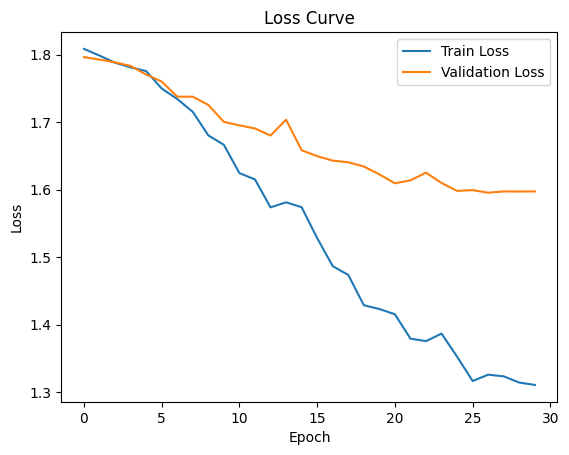

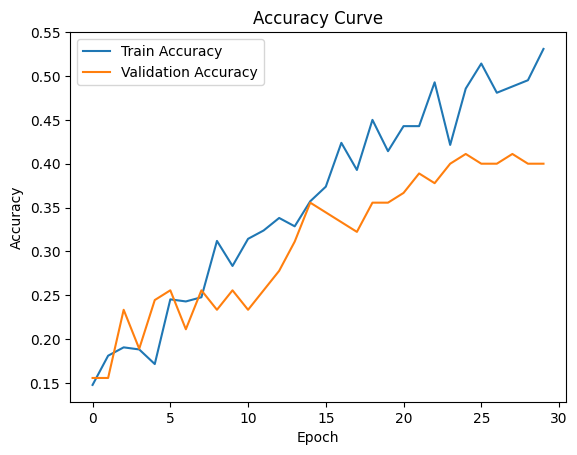

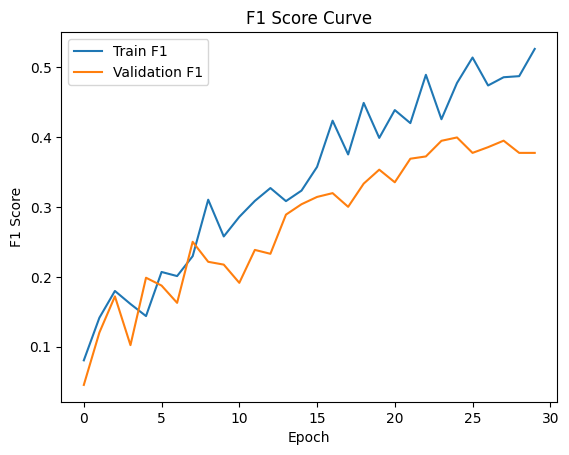

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8085,1.7964,0.1476,0.1556,0.0805,0.0453
1,2,1.7987,1.7927,0.1810,0.1556,0.1414,0.1202
2,3,1.7880,1.7887,0.1905,0.2333,0.1798,0.1720
3,4,1.7813,1.7833,0.1881,0.1889,0.1611,0.1022
4,5,1.7756,1.7706,0.1714,0.2444,0.1438,0.1987
5,6,1.7499,1.7602,0.2452,0.2556,0.2069,0.1875
6,7,1.7344,1.7378,0.2429,0.2111,0.2011,0.1627
7,8,1.7153,1.7378,0.2476,0.2556,0.2295,0.2501
8,9,1.6805,1.7256,0.3119,0.2333,0.3104,0.2215
9,10,1.6664,1.7005,0.2833,0.2556,0.2578,0.2175


In [10]:
intra_aggr, inter_aggr = aggr_list[i]
i += 1

experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# ('mean', 'sum')

Epoch 1/30
Train Loss: 1.8080 | Validation Loss: 1.7977
Train Acc: 0.1524 | Validation Acc: 0.1556
Train F1: 0.0724 | Validation F1: 0.0453

Epoch 2/30
Train Loss: 1.7995 | Validation Loss: 1.7937
Train Acc: 0.1714 | Validation Acc: 0.1778
Train F1: 0.1219 | Validation F1: 0.0876

Epoch 3/30
Train Loss: 1.7900 | Validation Loss: 1.7885
Train Acc: 0.1952 | Validation Acc: 0.1889
Train F1: 0.1826 | Validation F1: 0.1511

Epoch 4/30
Train Loss: 1.7837 | Validation Loss: 1.7827
Train Acc: 0.1762 | Validation Acc: 0.2111
Train F1: 0.1573 | Validation F1: 0.1152

Epoch 5/30
Train Loss: 1.7784 | Validation Loss: 1.7725
Train Acc: 0.1667 | Validation Acc: 0.1667
Train F1: 0.1405 | Validation F1: 0.1361

Epoch 6/30
Train Loss: 1.7530 | Validation Loss: 1.7630
Train Acc: 0.2381 | Validation Acc: 0.2333
Train F1: 0.2143 | Validation F1: 0.1647

Epoch 7/30
Train Loss: 1.7443 | Validation Loss: 1.7448
Train Acc: 0.2500 | Validation Acc: 0.2000
Train F1: 0.2132 | Validation F1: 0.1505

Epoch 8/30
Tr

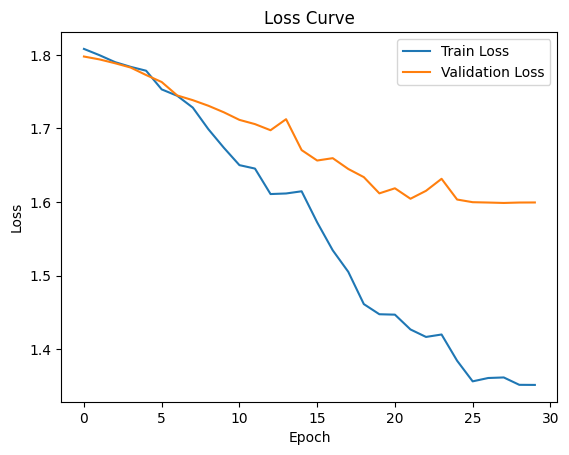

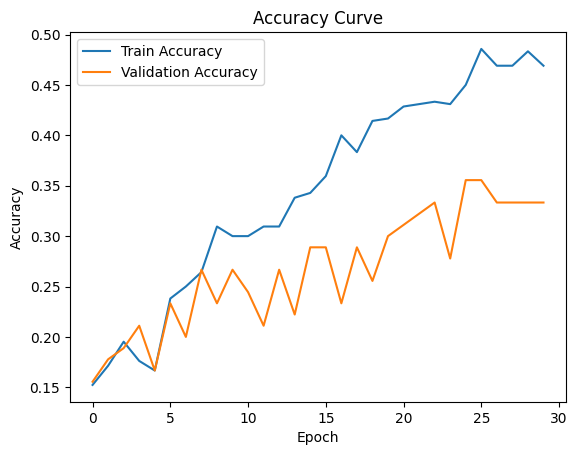

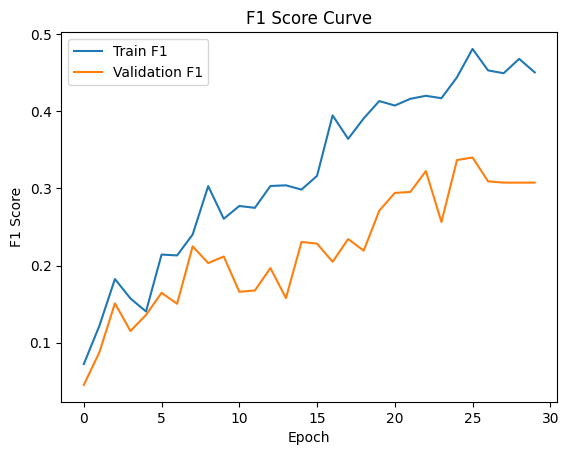

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8080,1.7977,0.1524,0.1556,0.0724,0.0453
1,2,1.7995,1.7937,0.1714,0.1778,0.1219,0.0876
2,3,1.7900,1.7885,0.1952,0.1889,0.1826,0.1511
3,4,1.7837,1.7827,0.1762,0.2111,0.1573,0.1152
4,5,1.7784,1.7725,0.1667,0.1667,0.1405,0.1361
5,6,1.7530,1.7630,0.2381,0.2333,0.2143,0.1647
6,7,1.7443,1.7448,0.2500,0.2000,0.2132,0.1505
7,8,1.7283,1.7384,0.2643,0.2667,0.2403,0.2249
8,9,1.6990,1.7308,0.3095,0.2333,0.3031,0.2033
9,10,1.6736,1.7219,0.3000,0.2667,0.2607,0.2118


In [11]:
intra_aggr, inter_aggr = aggr_list[i]
i += 1

experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# ('mean', 'mean')

Epoch 1/30
Train Loss: 1.8061 | Validation Loss: 1.7974
Train Acc: 0.1595 | Validation Acc: 0.1556
Train F1: 0.0839 | Validation F1: 0.0453

Epoch 2/30
Train Loss: 1.7993 | Validation Loss: 1.7940
Train Acc: 0.1714 | Validation Acc: 0.1667
Train F1: 0.1228 | Validation F1: 0.0666

Epoch 3/30
Train Loss: 1.7912 | Validation Loss: 1.7892
Train Acc: 0.1762 | Validation Acc: 0.1444
Train F1: 0.1578 | Validation F1: 0.1190

Epoch 4/30
Train Loss: 1.7851 | Validation Loss: 1.7835
Train Acc: 0.1762 | Validation Acc: 0.2000
Train F1: 0.1663 | Validation F1: 0.1083

Epoch 5/30
Train Loss: 1.7819 | Validation Loss: 1.7745
Train Acc: 0.1667 | Validation Acc: 0.2111
Train F1: 0.1396 | Validation F1: 0.1528

Epoch 6/30
Train Loss: 1.7613 | Validation Loss: 1.7653
Train Acc: 0.2214 | Validation Acc: 0.2444
Train F1: 0.1973 | Validation F1: 0.1686

Epoch 7/30
Train Loss: 1.7480 | Validation Loss: 1.7514
Train Acc: 0.2500 | Validation Acc: 0.2333
Train F1: 0.2057 | Validation F1: 0.1462

Epoch 8/30
Tr

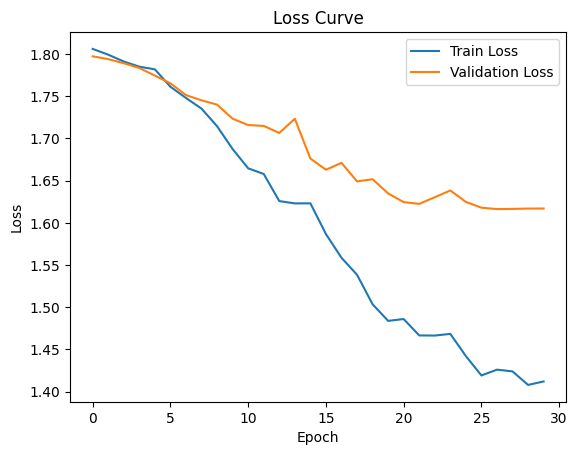

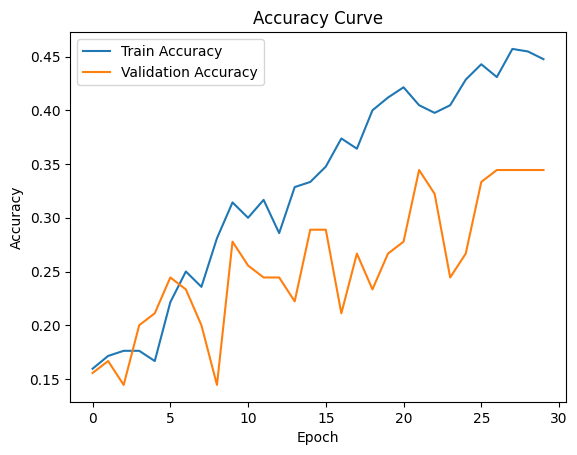

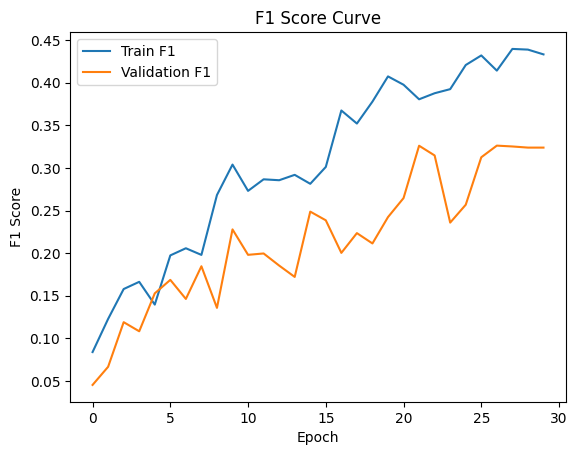

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8061,1.7974,0.1595,0.1556,0.0839,0.0453
1,2,1.7993,1.7940,0.1714,0.1667,0.1228,0.0666
2,3,1.7912,1.7892,0.1762,0.1444,0.1578,0.1190
3,4,1.7851,1.7835,0.1762,0.2000,0.1663,0.1083
4,5,1.7819,1.7745,0.1667,0.2111,0.1396,0.1528
5,6,1.7613,1.7653,0.2214,0.2444,0.1973,0.1686
6,7,1.7480,1.7514,0.2500,0.2333,0.2057,0.1462
7,8,1.7353,1.7452,0.2357,0.2000,0.1979,0.1846
8,9,1.7145,1.7401,0.2810,0.1444,0.2682,0.1357
9,10,1.6875,1.7234,0.3143,0.2778,0.3039,0.2278


In [12]:
intra_aggr, inter_aggr = aggr_list[i]
i += 1

experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# ('mean', 'max')

Epoch 1/30
Train Loss: 1.8074 | Validation Loss: 1.7974
Train Acc: 0.1571 | Validation Acc: 0.1556
Train F1: 0.0798 | Validation F1: 0.0453

Epoch 2/30
Train Loss: 1.8000 | Validation Loss: 1.7938
Train Acc: 0.1690 | Validation Acc: 0.1778
Train F1: 0.1183 | Validation F1: 0.0879

Epoch 3/30
Train Loss: 1.7912 | Validation Loss: 1.7887
Train Acc: 0.1810 | Validation Acc: 0.1444
Train F1: 0.1653 | Validation F1: 0.1192

Epoch 4/30
Train Loss: 1.7849 | Validation Loss: 1.7830
Train Acc: 0.1762 | Validation Acc: 0.2111
Train F1: 0.1642 | Validation F1: 0.1129

Epoch 5/30
Train Loss: 1.7810 | Validation Loss: 1.7738
Train Acc: 0.1738 | Validation Acc: 0.1889
Train F1: 0.1453 | Validation F1: 0.1383

Epoch 6/30
Train Loss: 1.7596 | Validation Loss: 1.7647
Train Acc: 0.2381 | Validation Acc: 0.2444
Train F1: 0.2129 | Validation F1: 0.1705

Epoch 7/30
Train Loss: 1.7475 | Validation Loss: 1.7500
Train Acc: 0.2524 | Validation Acc: 0.2333
Train F1: 0.2117 | Validation F1: 0.1458

Epoch 8/30
Tr

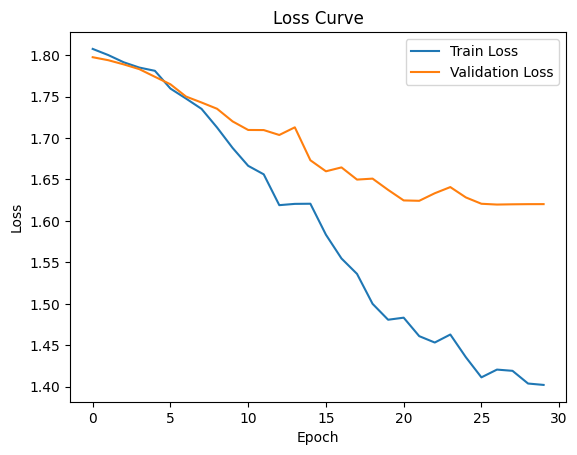

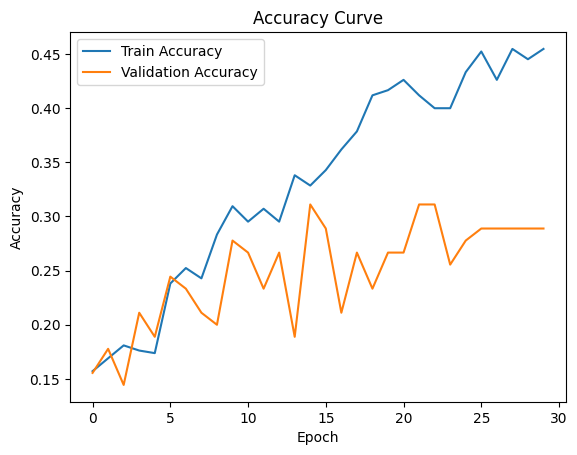

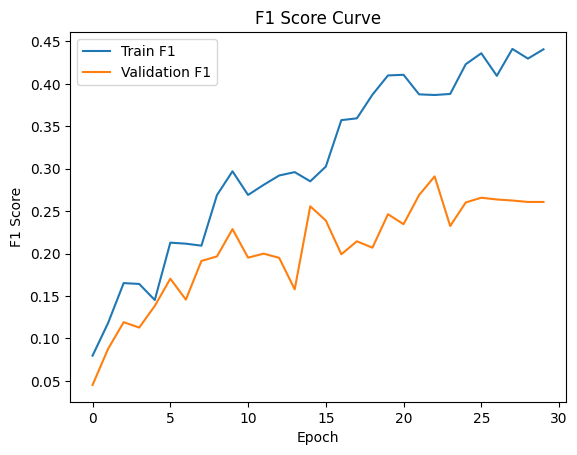

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8074,1.7974,0.1571,0.1556,0.0798,0.0453
1,2,1.8000,1.7938,0.1690,0.1778,0.1183,0.0879
2,3,1.7912,1.7887,0.1810,0.1444,0.1653,0.1192
3,4,1.7849,1.7830,0.1762,0.2111,0.1642,0.1129
4,5,1.7810,1.7738,0.1738,0.1889,0.1453,0.1383
5,6,1.7596,1.7647,0.2381,0.2444,0.2129,0.1705
6,7,1.7475,1.7500,0.2524,0.2333,0.2117,0.1458
7,8,1.7351,1.7428,0.2429,0.2111,0.2094,0.1914
8,9,1.7126,1.7352,0.2833,0.2000,0.2689,0.1967
9,10,1.6880,1.7200,0.3095,0.2778,0.2970,0.2289


In [13]:
intra_aggr, inter_aggr = aggr_list[i]
i += 1

experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# ('max', 'sum')

/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1/30
Train Loss: 1.8085 | Validation Loss: 1.7974
Train Acc: 0.1500 | Validation Acc: 0.1556
Train F1: 0.0741 | Validation F1: 0.0453



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2/30
Train Loss: 1.7989 | Validation Loss: 1.7937
Train Acc: 0.1738 | Validation Acc: 0.1667
Train F1: 0.1319 | Validation F1: 0.0657



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3/30
Train Loss: 1.7880 | Validation Loss: 1.7891
Train Acc: 0.1881 | Validation Acc: 0.2222
Train F1: 0.1829 | Validation F1: 0.1667



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4/30
Train Loss: 1.7817 | Validation Loss: 1.7835
Train Acc: 0.1857 | Validation Acc: 0.2111
Train F1: 0.1610 | Validation F1: 0.1139



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5/30
Train Loss: 1.7740 | Validation Loss: 1.7722
Train Acc: 0.1690 | Validation Acc: 0.1889
Train F1: 0.1450 | Validation F1: 0.1583



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6/30
Train Loss: 1.7462 | Validation Loss: 1.7627
Train Acc: 0.2667 | Validation Acc: 0.2444
Train F1: 0.2307 | Validation F1: 0.1835



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7/30
Train Loss: 1.7357 | Validation Loss: 1.7422
Train Acc: 0.2476 | Validation Acc: 0.2444
Train F1: 0.2057 | Validation F1: 0.1914



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8/30
Train Loss: 1.7135 | Validation Loss: 1.7409
Train Acc: 0.2595 | Validation Acc: 0.2111
Train F1: 0.2281 | Validation F1: 0.1736



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9/30
Train Loss: 1.6819 | Validation Loss: 1.7327
Train Acc: 0.3000 | Validation Acc: 0.2667
Train F1: 0.2999 | Validation F1: 0.2117



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10/30
Train Loss: 1.6651 | Validation Loss: 1.7148
Train Acc: 0.3000 | Validation Acc: 0.2667
Train F1: 0.2617 | Validation F1: 0.2212



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 11/30
Train Loss: 1.6341 | Validation Loss: 1.7071
Train Acc: 0.3071 | Validation Acc: 0.2444
Train F1: 0.2785 | Validation F1: 0.1947



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 12/30
Train Loss: 1.6303 | Validation Loss: 1.6976
Train Acc: 0.3143 | Validation Acc: 0.2889
Train F1: 0.2924 | Validation F1: 0.2504



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 13/30
Train Loss: 1.5912 | Validation Loss: 1.6887
Train Acc: 0.3238 | Validation Acc: 0.2778
Train F1: 0.3127 | Validation F1: 0.2325



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 14/30
Train Loss: 1.5980 | Validation Loss: 1.7347
Train Acc: 0.3262 | Validation Acc: 0.2333
Train F1: 0.2914 | Validation F1: 0.1806



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 15/30
Train Loss: 1.6017 | Validation Loss: 1.6710
Train Acc: 0.3357 | Validation Acc: 0.2667
Train F1: 0.2926 | Validation F1: 0.2081



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 16/30
Train Loss: 1.5503 | Validation Loss: 1.6575
Train Acc: 0.3738 | Validation Acc: 0.2667
Train F1: 0.3491 | Validation F1: 0.2275



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 17/30
Train Loss: 1.5027 | Validation Loss: 1.6580
Train Acc: 0.4262 | Validation Acc: 0.2333
Train F1: 0.4225 | Validation F1: 0.2056



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 18/30
Train Loss: 1.4764 | Validation Loss: 1.6594
Train Acc: 0.4143 | Validation Acc: 0.2889
Train F1: 0.4045 | Validation F1: 0.2412



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 19/30
Train Loss: 1.4222 | Validation Loss: 1.6411
Train Acc: 0.4429 | Validation Acc: 0.2889
Train F1: 0.4313 | Validation F1: 0.2639



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 20/30
Train Loss: 1.4244 | Validation Loss: 1.6295
Train Acc: 0.4310 | Validation Acc: 0.2667
Train F1: 0.4209 | Validation F1: 0.2419



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 21/30
Train Loss: 1.4056 | Validation Loss: 1.6105
Train Acc: 0.4476 | Validation Acc: 0.3222
Train F1: 0.4412 | Validation F1: 0.3027



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 22/30
Train Loss: 1.3770 | Validation Loss: 1.6126
Train Acc: 0.4595 | Validation Acc: 0.3111
Train F1: 0.4485 | Validation F1: 0.2771



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 23/30
Train Loss: 1.3641 | Validation Loss: 1.6286
Train Acc: 0.4833 | Validation Acc: 0.3111
Train F1: 0.4741 | Validation F1: 0.2843



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 24/30
Train Loss: 1.3780 | Validation Loss: 1.6173
Train Acc: 0.4452 | Validation Acc: 0.2778
Train F1: 0.4465 | Validation F1: 0.2555



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 25/30
Train Loss: 1.3411 | Validation Loss: 1.5998
Train Acc: 0.4833 | Validation Acc: 0.3111
Train F1: 0.4754 | Validation F1: 0.2851



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 26/30
Train Loss: 1.3100 | Validation Loss: 1.6020
Train Acc: 0.5095 | Validation Acc: 0.3222
Train F1: 0.5105 | Validation F1: 0.3011



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 27/30
Train Loss: 1.3193 | Validation Loss: 1.5980
Train Acc: 0.4810 | Validation Acc: 0.3000
Train F1: 0.4754 | Validation F1: 0.2711



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 28/30
Train Loss: 1.3138 | Validation Loss: 1.5990
Train Acc: 0.4952 | Validation Acc: 0.3000
Train F1: 0.4889 | Validation F1: 0.2693



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 29/30
Train Loss: 1.3098 | Validation Loss: 1.5988
Train Acc: 0.4881 | Validation Acc: 0.3000
Train F1: 0.4816 | Validation F1: 0.2702



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 30/30
Train Loss: 1.3018 | Validation Loss: 1.5988
Train Acc: 0.5071 | Validation Acc: 0.3000
Train F1: 0.4993 | Validation F1: 0.2702



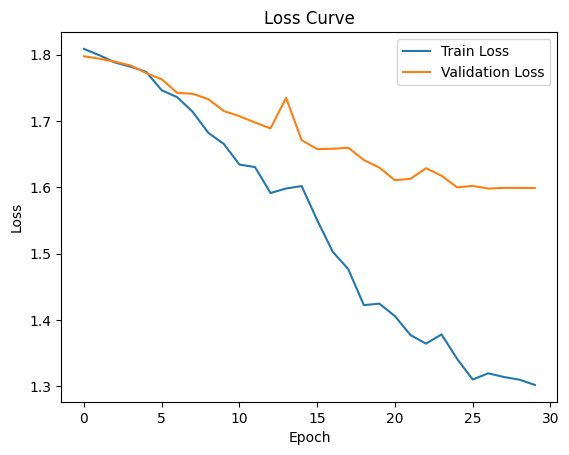

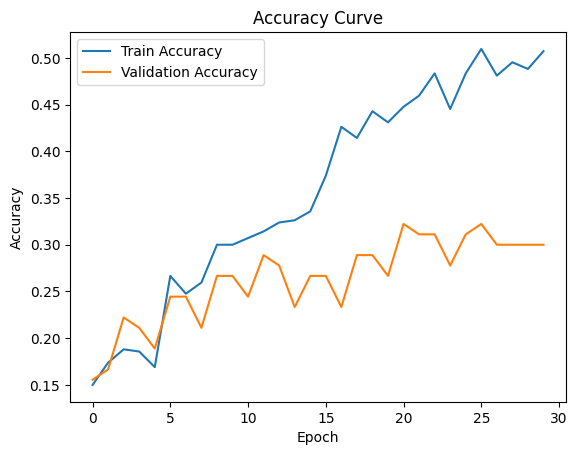

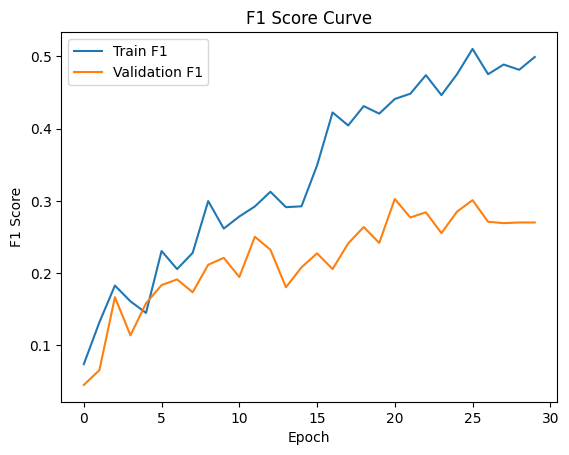

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8085,1.7974,0.1500,0.1556,0.0741,0.0453
1,2,1.7989,1.7937,0.1738,0.1667,0.1319,0.0657
2,3,1.7880,1.7891,0.1881,0.2222,0.1829,0.1667
3,4,1.7817,1.7835,0.1857,0.2111,0.1610,0.1139
4,5,1.7740,1.7722,0.1690,0.1889,0.1450,0.1583
5,6,1.7462,1.7627,0.2667,0.2444,0.2307,0.1835
6,7,1.7357,1.7422,0.2476,0.2444,0.2057,0.1914
7,8,1.7135,1.7409,0.2595,0.2111,0.2281,0.1736
8,9,1.6819,1.7327,0.3000,0.2667,0.2999,0.2117
9,10,1.6651,1.7148,0.3000,0.2667,0.2617,0.2212


In [14]:
intra_aggr, inter_aggr = aggr_list[i]
i += 1

experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# ('max', 'mean')

/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1/30
Train Loss: 1.8061 | Validation Loss: 1.7973
Train Acc: 0.1524 | Validation Acc: 0.1556
Train F1: 0.0870 | Validation F1: 0.0453



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2/30
Train Loss: 1.7988 | Validation Loss: 1.7942
Train Acc: 0.1810 | Validation Acc: 0.1667
Train F1: 0.1425 | Validation F1: 0.0666



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3/30
Train Loss: 1.7898 | Validation Loss: 1.7901
Train Acc: 0.1786 | Validation Acc: 0.1667
Train F1: 0.1644 | Validation F1: 0.1267



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4/30
Train Loss: 1.7840 | Validation Loss: 1.7850
Train Acc: 0.1810 | Validation Acc: 0.2111
Train F1: 0.1667 | Validation F1: 0.1129



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5/30
Train Loss: 1.7801 | Validation Loss: 1.7756
Train Acc: 0.1667 | Validation Acc: 0.2222
Train F1: 0.1411 | Validation F1: 0.1593



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6/30
Train Loss: 1.7570 | Validation Loss: 1.7666
Train Acc: 0.2357 | Validation Acc: 0.2444
Train F1: 0.2038 | Validation F1: 0.1712



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7/30
Train Loss: 1.7424 | Validation Loss: 1.7514
Train Acc: 0.2619 | Validation Acc: 0.2444
Train F1: 0.2164 | Validation F1: 0.1685



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8/30
Train Loss: 1.7262 | Validation Loss: 1.7458
Train Acc: 0.2500 | Validation Acc: 0.2222
Train F1: 0.2112 | Validation F1: 0.1836



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9/30
Train Loss: 1.7007 | Validation Loss: 1.7381
Train Acc: 0.3000 | Validation Acc: 0.2333
Train F1: 0.2943 | Validation F1: 0.2062



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10/30
Train Loss: 1.6754 | Validation Loss: 1.7220
Train Acc: 0.2857 | Validation Acc: 0.2667
Train F1: 0.2508 | Validation F1: 0.2157



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 11/30
Train Loss: 1.6474 | Validation Loss: 1.7146
Train Acc: 0.3048 | Validation Acc: 0.2556
Train F1: 0.2760 | Validation F1: 0.1908



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 12/30
Train Loss: 1.6456 | Validation Loss: 1.7053
Train Acc: 0.3048 | Validation Acc: 0.2222
Train F1: 0.2822 | Validation F1: 0.1846



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 13/30
Train Loss: 1.6095 | Validation Loss: 1.6929
Train Acc: 0.2976 | Validation Acc: 0.2778
Train F1: 0.2854 | Validation F1: 0.2273



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 14/30
Train Loss: 1.6141 | Validation Loss: 1.7368
Train Acc: 0.3167 | Validation Acc: 0.2222
Train F1: 0.2751 | Validation F1: 0.1616



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 15/30
Train Loss: 1.6197 | Validation Loss: 1.6753
Train Acc: 0.3262 | Validation Acc: 0.2667
Train F1: 0.2770 | Validation F1: 0.2037



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 16/30
Train Loss: 1.5675 | Validation Loss: 1.6633
Train Acc: 0.3429 | Validation Acc: 0.2778
Train F1: 0.2983 | Validation F1: 0.2203



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 17/30
Train Loss: 1.5356 | Validation Loss: 1.6625
Train Acc: 0.3881 | Validation Acc: 0.2111
Train F1: 0.3792 | Validation F1: 0.1917



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 18/30
Train Loss: 1.5120 | Validation Loss: 1.6548
Train Acc: 0.3881 | Validation Acc: 0.3000
Train F1: 0.3789 | Validation F1: 0.2581



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 19/30
Train Loss: 1.4662 | Validation Loss: 1.6559
Train Acc: 0.4238 | Validation Acc: 0.2889
Train F1: 0.4085 | Validation F1: 0.2457



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 20/30
Train Loss: 1.4545 | Validation Loss: 1.6327
Train Acc: 0.4048 | Validation Acc: 0.2778
Train F1: 0.3995 | Validation F1: 0.2464



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 21/30
Train Loss: 1.4537 | Validation Loss: 1.6265
Train Acc: 0.4381 | Validation Acc: 0.3000
Train F1: 0.4301 | Validation F1: 0.2834



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 22/30
Train Loss: 1.4260 | Validation Loss: 1.6217
Train Acc: 0.4333 | Validation Acc: 0.3111
Train F1: 0.4176 | Validation F1: 0.2837



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 23/30
Train Loss: 1.4203 | Validation Loss: 1.6343
Train Acc: 0.4333 | Validation Acc: 0.3222
Train F1: 0.4262 | Validation F1: 0.2932



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 24/30
Train Loss: 1.4258 | Validation Loss: 1.6381
Train Acc: 0.4286 | Validation Acc: 0.2667
Train F1: 0.4294 | Validation F1: 0.2500



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 25/30
Train Loss: 1.3944 | Validation Loss: 1.6180
Train Acc: 0.4524 | Validation Acc: 0.3333
Train F1: 0.4497 | Validation F1: 0.3096



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 26/30
Train Loss: 1.3698 | Validation Loss: 1.6145
Train Acc: 0.4810 | Validation Acc: 0.3444
Train F1: 0.4762 | Validation F1: 0.3181



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 27/30
Train Loss: 1.3771 | Validation Loss: 1.6129
Train Acc: 0.4571 | Validation Acc: 0.3444
Train F1: 0.4516 | Validation F1: 0.3181



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 28/30
Train Loss: 1.3702 | Validation Loss: 1.6135
Train Acc: 0.4571 | Validation Acc: 0.3444
Train F1: 0.4483 | Validation F1: 0.3181



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 29/30
Train Loss: 1.3594 | Validation Loss: 1.6134
Train Acc: 0.4571 | Validation Acc: 0.3444
Train F1: 0.4487 | Validation F1: 0.3181



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 30/30
Train Loss: 1.3568 | Validation Loss: 1.6135
Train Acc: 0.4643 | Validation Acc: 0.3444
Train F1: 0.4624 | Validation F1: 0.3181



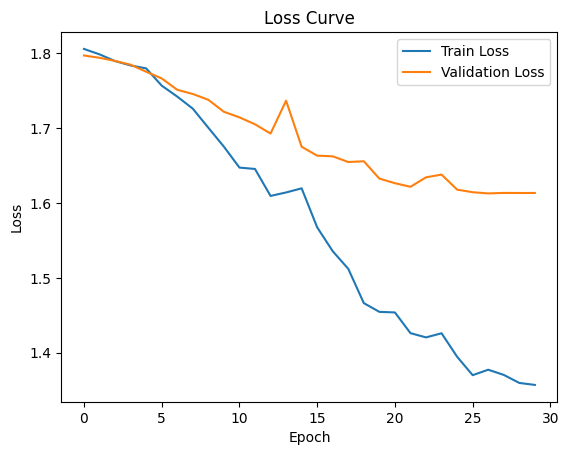

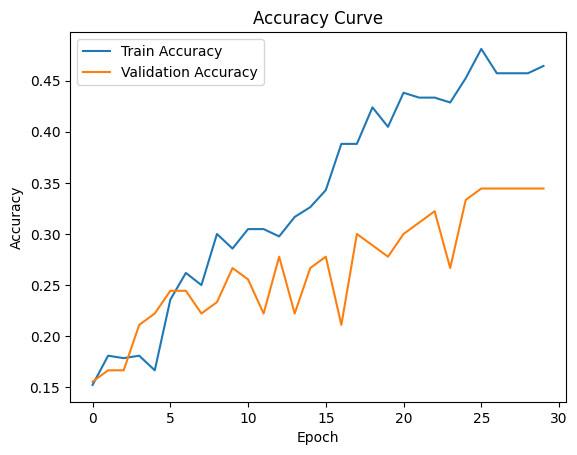

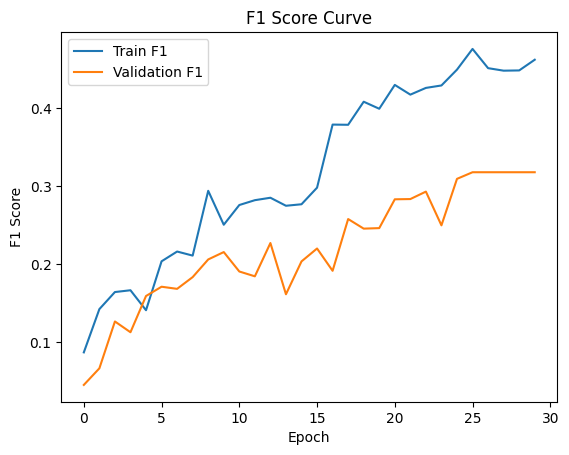

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8061,1.7973,0.1524,0.1556,0.0870,0.0453
1,2,1.7988,1.7942,0.1810,0.1667,0.1425,0.0666
2,3,1.7898,1.7901,0.1786,0.1667,0.1644,0.1267
3,4,1.7840,1.7850,0.1810,0.2111,0.1667,0.1129
4,5,1.7801,1.7756,0.1667,0.2222,0.1411,0.1593
5,6,1.7570,1.7666,0.2357,0.2444,0.2038,0.1712
6,7,1.7424,1.7514,0.2619,0.2444,0.2164,0.1685
7,8,1.7262,1.7458,0.2500,0.2222,0.2112,0.1836
8,9,1.7007,1.7381,0.3000,0.2333,0.2943,0.2062
9,10,1.6754,1.7220,0.2857,0.2667,0.2508,0.2157


In [15]:
intra_aggr, inter_aggr = aggr_list[i]
i += 1

experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# ('max', 'max')

/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 1/30
Train Loss: 1.8079 | Validation Loss: 1.7972
Train Acc: 0.1548 | Validation Acc: 0.1556
Train F1: 0.0829 | Validation F1: 0.0453



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 2/30
Train Loss: 1.7994 | Validation Loss: 1.7938
Train Acc: 0.1714 | Validation Acc: 0.1778
Train F1: 0.1298 | Validation F1: 0.0883



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 3/30
Train Loss: 1.7893 | Validation Loss: 1.7895
Train Acc: 0.1833 | Validation Acc: 0.1778
Train F1: 0.1702 | Validation F1: 0.1315



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 4/30
Train Loss: 1.7834 | Validation Loss: 1.7843
Train Acc: 0.1833 | Validation Acc: 0.2111
Train F1: 0.1687 | Validation F1: 0.1129



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 5/30
Train Loss: 1.7784 | Validation Loss: 1.7745
Train Acc: 0.1643 | Validation Acc: 0.1778
Train F1: 0.1390 | Validation F1: 0.1354



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 6/30
Train Loss: 1.7546 | Validation Loss: 1.7655
Train Acc: 0.2310 | Validation Acc: 0.2444
Train F1: 0.1971 | Validation F1: 0.1711



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 7/30
Train Loss: 1.7414 | Validation Loss: 1.7488
Train Acc: 0.2429 | Validation Acc: 0.2333
Train F1: 0.2028 | Validation F1: 0.1641



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 8/30
Train Loss: 1.7249 | Validation Loss: 1.7433
Train Acc: 0.2571 | Validation Acc: 0.2333
Train F1: 0.2226 | Validation F1: 0.1921



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 9/30
Train Loss: 1.6982 | Validation Loss: 1.7322
Train Acc: 0.2952 | Validation Acc: 0.2222
Train F1: 0.2873 | Validation F1: 0.1966



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 10/30
Train Loss: 1.6783 | Validation Loss: 1.7166
Train Acc: 0.2833 | Validation Acc: 0.2667
Train F1: 0.2478 | Validation F1: 0.2151



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 11/30
Train Loss: 1.6457 | Validation Loss: 1.7110
Train Acc: 0.3000 | Validation Acc: 0.2111
Train F1: 0.2728 | Validation F1: 0.1678



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 12/30
Train Loss: 1.6394 | Validation Loss: 1.7024
Train Acc: 0.3167 | Validation Acc: 0.2222
Train F1: 0.2912 | Validation F1: 0.1999



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 13/30
Train Loss: 1.6048 | Validation Loss: 1.6922
Train Acc: 0.3119 | Validation Acc: 0.2667
Train F1: 0.2970 | Validation F1: 0.2199



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 14/30
Train Loss: 1.6077 | Validation Loss: 1.7232
Train Acc: 0.3214 | Validation Acc: 0.2111
Train F1: 0.2823 | Validation F1: 0.1540



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 15/30
Train Loss: 1.6058 | Validation Loss: 1.6720
Train Acc: 0.3310 | Validation Acc: 0.2889
Train F1: 0.2836 | Validation F1: 0.2289



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 16/30
Train Loss: 1.5600 | Validation Loss: 1.6628
Train Acc: 0.3429 | Validation Acc: 0.2667
Train F1: 0.3028 | Validation F1: 0.2290



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 17/30
Train Loss: 1.5276 | Validation Loss: 1.6653
Train Acc: 0.3905 | Validation Acc: 0.2000
Train F1: 0.3853 | Validation F1: 0.1775



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 18/30
Train Loss: 1.5052 | Validation Loss: 1.6517
Train Acc: 0.3881 | Validation Acc: 0.2556
Train F1: 0.3713 | Validation F1: 0.2159



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 19/30
Train Loss: 1.4615 | Validation Loss: 1.6488
Train Acc: 0.4333 | Validation Acc: 0.2667
Train F1: 0.4195 | Validation F1: 0.2378



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 20/30
Train Loss: 1.4506 | Validation Loss: 1.6375
Train Acc: 0.4000 | Validation Acc: 0.2667
Train F1: 0.3907 | Validation F1: 0.2513



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 21/30
Train Loss: 1.4525 | Validation Loss: 1.6248
Train Acc: 0.4190 | Validation Acc: 0.3222
Train F1: 0.4056 | Validation F1: 0.3045



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 22/30
Train Loss: 1.4157 | Validation Loss: 1.6216
Train Acc: 0.4357 | Validation Acc: 0.2889
Train F1: 0.4138 | Validation F1: 0.2611



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 23/30
Train Loss: 1.4147 | Validation Loss: 1.6350
Train Acc: 0.4333 | Validation Acc: 0.3556
Train F1: 0.4253 | Validation F1: 0.3338



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 24/30
Train Loss: 1.4188 | Validation Loss: 1.6385
Train Acc: 0.4310 | Validation Acc: 0.2889
Train F1: 0.4331 | Validation F1: 0.2744



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 25/30
Train Loss: 1.3886 | Validation Loss: 1.6206
Train Acc: 0.4595 | Validation Acc: 0.3111
Train F1: 0.4545 | Validation F1: 0.2928



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 26/30
Train Loss: 1.3663 | Validation Loss: 1.6157
Train Acc: 0.4857 | Validation Acc: 0.3556
Train F1: 0.4778 | Validation F1: 0.3392



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 27/30
Train Loss: 1.3698 | Validation Loss: 1.6142
Train Acc: 0.4524 | Validation Acc: 0.3444
Train F1: 0.4439 | Validation F1: 0.3299



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 28/30
Train Loss: 1.3685 | Validation Loss: 1.6144
Train Acc: 0.4619 | Validation Acc: 0.3111
Train F1: 0.4553 | Validation F1: 0.2978



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 29/30
Train Loss: 1.3592 | Validation Loss: 1.6146
Train Acc: 0.4548 | Validation Acc: 0.3444
Train F1: 0.4435 | Validation F1: 0.3299



/home/galvanized_heart/MIE1520_Final_Project/ML_ENV/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 30/30
Train Loss: 1.3518 | Validation Loss: 1.6146
Train Acc: 0.4643 | Validation Acc: 0.3444
Train F1: 0.4580 | Validation F1: 0.3299



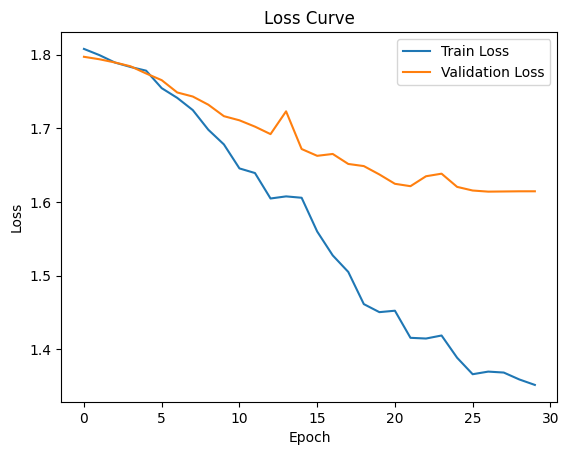

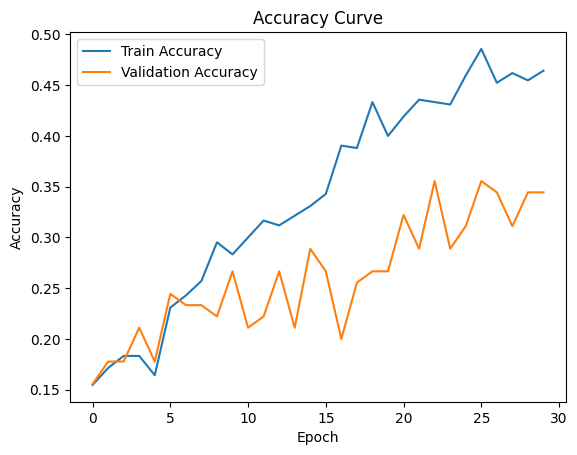

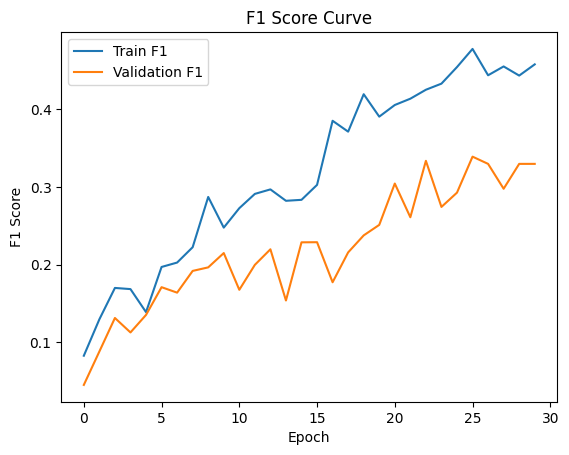

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8079,1.7972,0.1548,0.1556,0.0829,0.0453
1,2,1.7994,1.7938,0.1714,0.1778,0.1298,0.0883
2,3,1.7893,1.7895,0.1833,0.1778,0.1702,0.1315
3,4,1.7834,1.7843,0.1833,0.2111,0.1687,0.1129
4,5,1.7784,1.7745,0.1643,0.1778,0.1390,0.1354
5,6,1.7546,1.7655,0.2310,0.2444,0.1971,0.1711
6,7,1.7414,1.7488,0.2429,0.2333,0.2028,0.1641
7,8,1.7249,1.7433,0.2571,0.2333,0.2226,0.1921
8,9,1.6982,1.7322,0.2952,0.2222,0.2873,0.1966
9,10,1.6783,1.7166,0.2833,0.2667,0.2478,0.2151


In [16]:
intra_aggr, inter_aggr = aggr_list[i]
i += 1

experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)